In [133]:
import numpy as np
import pygimli as pg
import  pygimli.meshtools       as     mt
from pygimli.viewer import pv
from pygimli.physics.gravimetry import MagneticsModelling
import  matplotlib.pyplot          as     plt


Mesh: Nodes: 4851 Cells: 4000 Boundaries: 12800


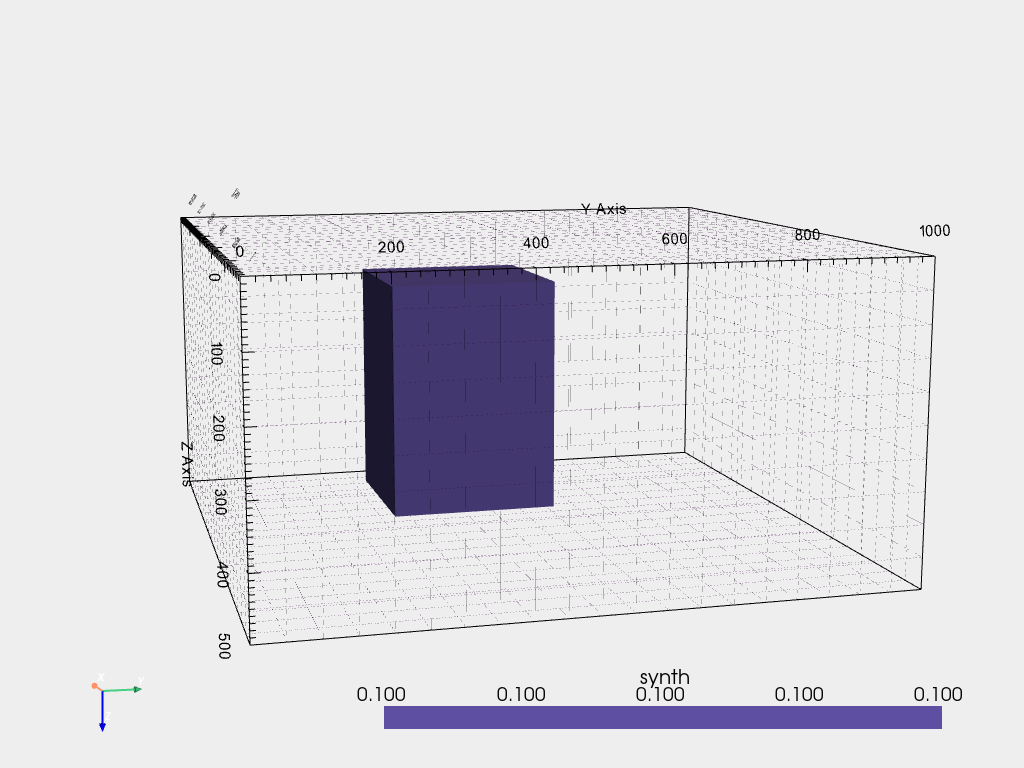

   0%|          |0/441 [00:00 < ?]

10/01/23 - 18:59:12 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.gravimetry.MagneticsModelling.MagneticsModelling object at 0x000001EA9ED6FF40>
Data transformation: <pgcore._pygimli_.RTrans object at 0x000001EABE518D60>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001EABE518880>
min/max (data): -1.0e-07/1.2e-06
min/max (error): 1.08%/110%
min/max (start model): 1.0e-03/1.0e-03
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 715.73 (dPhi = 22.69%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 384.53 (dPhi = 45.62%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 51.79 (dPhi = 83.86%) lam: 10.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 3.06 (dPhi = 73.41%) lam: 10.0
--

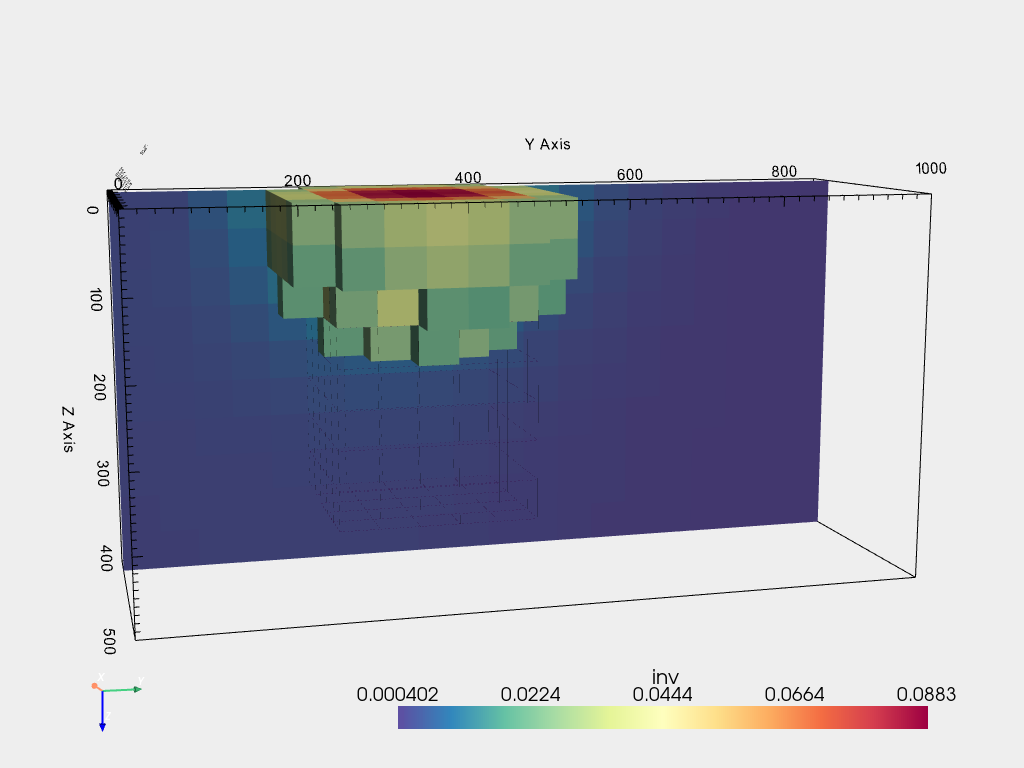

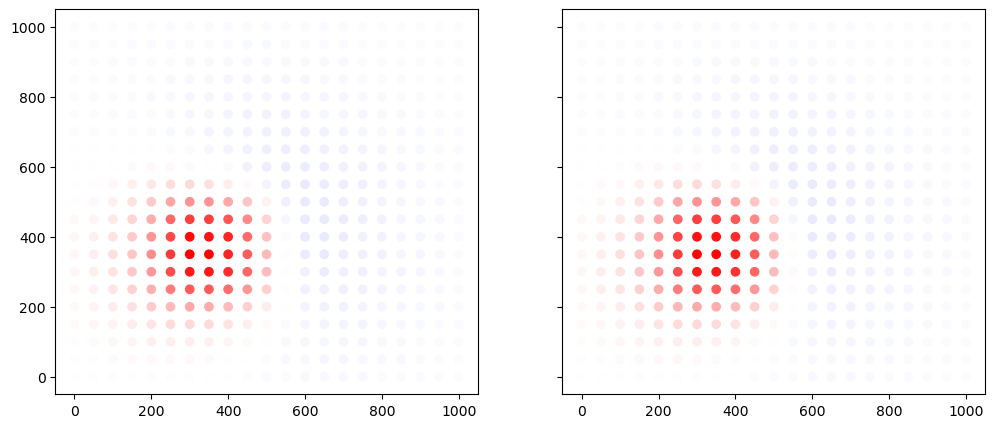

In [220]:
##
# Copy Paste from tutorial
##
dx = 50
x = np.arange(0., 1001, dx)
y = np.arange(0., 1001, dx)
z = np.arange(0., 501, dx)
grid = pg.createGrid(x, y, z)
print(grid)

v = np.zeros((len(z)-1, len(y)-1, len(x)-1))
# for i in range(7):
#     v[1+i, 11-i:16-i, 7:13] = 0.05
v[1:8,5:10,5:10] = 0.1

grid["synth"] = v.ravel()

pl, _ = pg.show(grid, style="wireframe", hold=True)
pv.drawMesh(pl, grid, label="synth", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180 - 15
pl.camera.elevation = 10
pl.camera.zoom(1.2)
pl.show()


F, I, D = 50000e-9, 75, 25
H = F * np.cos(np.deg2rad(I))
X = H * np.cos(np.deg2rad(D))
Y = H * np.sin(np.deg2rad(D))
Z = F * np.sin(np.deg2rad(I))
igrf = [D, I, H, X, Y, Z, F]

py, px = np.meshgrid(x, y)
px = px.ravel()
py = py.ravel()
points = np.column_stack((px, py, -np.ones_like(px)*20))

# The forward operator
cmp = ["TFA"]  # ["Bx", "By", "Bz"]
fop = MagneticsModelling(grid, points, cmp, igrf)
model = pg.Vector(grid.cellCount(), 1.0)
data = fop.response(grid["synth"])

err = 0.01
noise_level = 1e-9
relError = noise_level / np.abs(data) + err
data *= np.random.randn(*data.shape)*relError + 1.0

# depth weighting
bz = np.array([b.center().z() for b in grid.boundaries() if not b.outside()])
z0 = 25
wz = 10 / (bz+z0)**1.5
fop.region(0).setConstraintWeights(wz)

inv = pg.Inversion(fop=fop, verbose=True)  # , debug=True)
inv.setRegularization(limits=[0, 0.1])  # to limit values
startModel = pg.Vector(grid.cellCount(), 0.001)
invmodel = inv.run(data, relError, lam=10., startModel=1e-3, verbose=True)
grid["inv"] = invmodel

pl, _ = pg.show(grid, label="synth", style="wireframe", hold=True,
                filter={"threshold": dict(value=0.025, scalars="synth")})
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.02, scalars="inv")})
pv.drawMesh(pl, grid, label="inv", style="surface", cMap="Spectral_r",
            filter={"slice": dict(normal=[-1, 0, 0], origin=[500, 600, 250])})
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180 - 15
pl.camera.elevation = 10
pl.camera.zoom(1.2)
pl.show()

fig, ax = pg.plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)
vals = data * 1e9
mm = np.max(np.abs(vals))
ax[0].scatter(px, py, c=vals, cmap="bwr", vmin=-mm, vmax=mm);
ax[1].scatter(px, py, c=inv.response*1e9, cmap="bwr", vmin=-mm, vmax=mm);

10/01/23 - 19:08:08 - pyGIMLi - WARNING - Deprecated code usage at:
10/01/23 - 19:08:08 - pyGIMLi - WARNING - None.<module>(C:\Users\azieg\AppData\Local\Temp\ipykernel_12768\580861368.py:11)
Mesh::cellMarker() Mesh::cellMarkers()


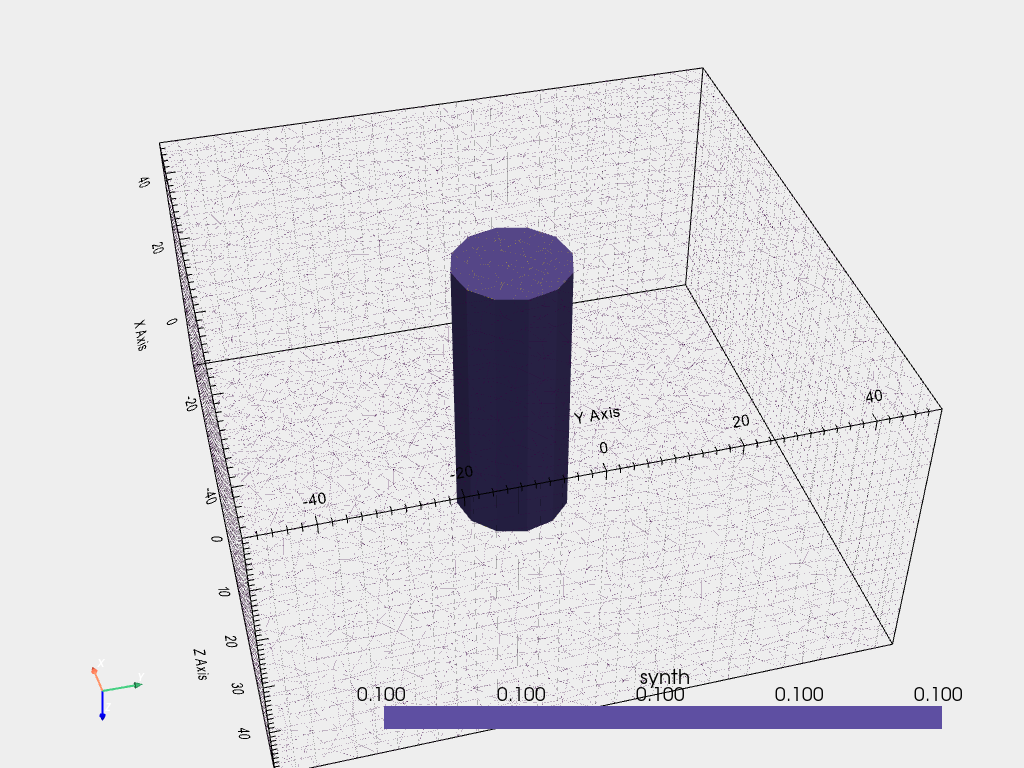

IndexError: tuple index out of range

In [224]:
##
# using an unstructured mesh instead of a grid
##
world = mt.createWorld([-50,-50], [50, 50])
circle = mt.createCircle(pos=[0, 0], radius=10, marker=2)
geom = world + circle
mesh = mt.createMesh(geom, area=10)
z=np.linspace(0,50,20)
mesh3d = mt.createMesh3D(mesh, z, topMarker=0, bottomMarker=0) 

v = np.array(mesh3d.cellMarker()) # List with RegionMarker for each cell
v[v==1] = 0
v[v==2] = 1
        
mesh3d["synth"] = v*0.1

pl, _ = pg.show(mesh3d, style="wireframe", hold=True)
pv.drawMesh(pl, mesh3d, label="synth", style="surface", cMap="Spectral_r",
            filter={"threshold": dict(value=0.05, scalars="synth")})
pl.camera_position = "yz"
pl.camera.roll = 90
pl.camera.azimuth = 180 - 15
pl.camera.elevation = 40
pl.camera.zoom(1.2)
pl.show()

F, I, D = 50000e-9, 75, 25
H = F * np.cos(np.deg2rad(I))
X = H * np.cos(np.deg2rad(D))
Y = H * np.sin(np.deg2rad(D))
Z = F * np.sin(np.deg2rad(I))
igrf = [D, I, H, X, Y, Z, F]


p_list = []
for n in mesh3d.nodes():
    if n[2]==0:
        p_list.append([n[0],n[1],n[2]])
points3d = np.array(p_list)
# plt.figure()
# plt.scatter(points3d[:,0],points3d[:,1])
# The forward operator
cmp = ["TFA"]  # ["Bx", "By", "Bz"]

fop = MagneticsModelling(mesh3d, points3d, cmp, igrf)
# model = pg.Vector(grid.cellCount(), 1.0)
# data = fop.response(grid["synth"])

In [283]:
#b_list does not convert from list to array properly
print(b_list)

#left and right cell count not working pproperly
bd_grid = grid.boundaries()[0]
bd_mesh3d = mesh3d.boundaries()[0]
print(bd_grid.leftCell())
print(bd_mesh3d.leftCell())
print(bd_mesh3d.rightCell())

bd_grid.allNodes()[0].id()

[list([62, 51, 64]) list([50, 21, 56]) list([26, 37, 36]) ...
 list([15787, 16643, 17520, 16664]) list([16531, 16656, 17533, 17408])
 list([15931, 16658, 17535, 16808])]
<pgcore._pygimli_.Hexahedron object at 0x000001EABD34F160>	ID: 0, Marker: 0, Size: 125000.0
	0 RVector3: (0.0, 0.0, 0.0)
	1 RVector3: (50.0, 0.0, 0.0)
	22 RVector3: (50.0, 50.0, 0.0)
	21 RVector3: (0.0, 50.0, 0.0)
	441 RVector3: (0.0, 0.0, 50.0)
	442 RVector3: (50.0, 0.0, 50.0)
	463 RVector3: (50.0, 50.0, 50.0)
	462 RVector3: (0.0, 50.0, 50.0)

None
None


1

In [279]:
pnts = points3d#points
mesh = mesh3d#grid

doB = np.any([c[0] == "B" and len(c) == 2 for c in cmp]) or "TFA" in cmp
doBT = np.any([c[0] == "B" and len(c) == 3 for c in cmp])
B_tens = None

kernel = np.zeros((mesh.cellCount(), len(pnts), len(cmp)))

if len(igrf) == 3:  # an X, Y, Z vector
    F = np.linalg.norm(igrf)
    fakt = F / (4*np.pi)
    B_dir = np.array(igrf) / F
elif len(igrf) == 7:  # an IGRF vector (D, I, H, X, Y, Z, F)
    fakt = igrf[6] / (4*np.pi)
    myigrf = np.array(igrf[3:6])
    B_dir = myigrf / np.linalg.norm(myigrf)
    
b_list, n_list, c_list = [], [], []
for bd in mesh.boundaries():
    b_list.append([n.id() for n in bd.allNodes()]) #list with 3 ids 
    c_list.append([bd.leftCell(), bd.rightCell()]) #all filled with none :(

# if pnts == points3d:
#     b_list_mesh3d = b_list
# else:
#     b_list_grid = b_list
    
    
b_list = np.array(b_list)
lb = b_list.shape

for nd in mesh.nodes():
    n_list.append(nd.pos())

n_list = np.array(n_list)

cl, cr = [], []
for i, c in enumerate(c_list):
    if c[0]:
        cl.append([i, c[0].id()])
    if c[1]:
        cr.append([i, c[1].id()])

cl = np.array(cl)
cr = np.array(cr)
rr = range(0, mesh.cellCount())
#rs = np.roll(range(0, lb[1]), -1)


C:\Users\azieg\AppData\Local\Temp\ipykernel_12768\452103199.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  b_list = np.array(b_list)


Mesh: Nodes: 441 Cells: 400 Boundaries: 840


   0%|          |0/1 [00:00 < ?]

ValueError: operands could not be broadcast together with shapes (840,2,3) (42,) 

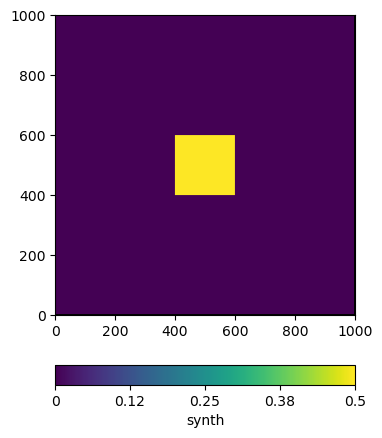

In [43]:
x = np.arange(0., 1001, dx)
y = np.arange(0., 1001, dx)
grid = pg.createGrid(x, y)
print(grid)

v = np.zeros((len(y)-1, len(x)-1))
# for i in range(7):
#     v[11-i:16-i, 7:13] = 0.5
v[8:12,8:12] = 0.5    
grid["synth"] = v.ravel()

pg.show(grid, data=grid["synth"], label="synth", showData=True)

F, I, D = 50000e-9, 75, 25
H = F * np.cos(np.deg2rad(I))
X = H * np.cos(np.deg2rad(D))
Y = H * np.sin(np.deg2rad(D))
Z = F * np.sin(np.deg2rad(I))
igrf = [D, I, H, X, Y, Z, F]

px = np.meshgrid(x)
points = np.column_stack((px, -np.ones_like(px)*20))

# The forward operator
cmp = ["TFA"]  # ["Bx", "By", "Bz"]
fop = MagneticsModelling(grid, points, cmp, igrf)